In [1]:
from MAUtil import *
from MAInit import *
from MACalc import *
from MAPost import *
import re
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 100)

In [2]:
from pymongo import MongoClient
client = MongoClient()
client = MongoClient('localhost', 27017)

In [3]:
db = client.adsE_database
collection = db.adsE_collection

### prepare data for prediction ###

In [4]:
dictlis = [{'element':'Cu', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Cu', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Ag', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Ag', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Pt', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Pt', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
#            {'element':'NiGa', 'mirror':'110', 'moved+':'no', 'moved':'no'},
#            {'element':'CoPt3', 'mirror':'100', 'moved+':'no', 'moved':'no'},
           {'element':'Pd', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Pd', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Au', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Au', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Al', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Al', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Ni', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Ni', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Rh', 'mirror':'100', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Rh', 'mirror':'111', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Ru', 'mirror':'000', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Zn', 'mirror':'000', 'converged':'yes', 'moved+':'no', 'moved':'no', 'unitlength':2},
          ]

In [5]:
results = []
for dic in dictlis:
    tmp = []
    for post in collection.find(dic):
        tmp.append(post)
    results.append(tmp)

df = []
dfpred = []

for i in range(len(results)):
    df.append(pd.DataFrame(results[i]))
    dfpred.append(df[i][df[i]['numberofads'] > 1])

for i in range(len(dfpred)):
    dfpred[i] = dfpred[i].reset_index()

In [6]:
### Exclude coverage > 1.0 ###
for i in range(len(dfpred)):
    dfpred[i] = dfpred[i][dfpred[i]['coverage'] <= 1.0]
    
### Exclude ads ene > 2.0 ###
for i in range(len(dfpred)):
    dfpred[i] = dfpred[i][dfpred[i]['aveadsEne/suratom'] >= -2.0]

In [7]:
covset = []
for i in range(len(df)):
    covset.append(sorted(list(set(dfpred[i]['coverage']))))
covset

[[0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75]]

### Predict ####

In [8]:
def predE(ele_mir, dfele, COinteractionflag ,CObondlengthflag):
    name = dfele['name']
    res = re.match('(.*u\d).*', name)
    barefile = res.group(1) + '.traj'
    bareatoms = query(barefile, 'spacom')
    slabE = bareatoms.get_potential_energy()
    
    igroups = dfele['igroups']
    adsElis = [] # adsE + slabE
    COEdifflis = []
    a2 = 46.252
    a1 = -106.43
    a0 = 46.754
    def COene(COlen):
        return a2*COlen**2 + a1*COlen + a0

    for i in range(len(igroups)):
        tmp = []
        tmp.append(igroups[i])
        try:
            adsE = df[ele_mir][(df[ele_mir]['unitlength']==dfele['unitlength'])&
                             (df[ele_mir]['numberofads']==1)&
                             (df[ele_mir]['igroups'].apply(lambda x: x==tmp))]['totaladsEnergy']
            adsElis.append(float(adsE))
        except:
#             print(name, 'One adsorbate result not found')
            return None
            
    Eint = dfele['ECO_Eint'] - COene(1.148)*dfele['numberofads']
    preadsdene = sum(adsElis)
    if COinteractionflag:
        preadsdene += Eint

    predadsene_surf = preadsdene/dfele['surfatomnum']

    return predadsene_surf, adsElis, Eint

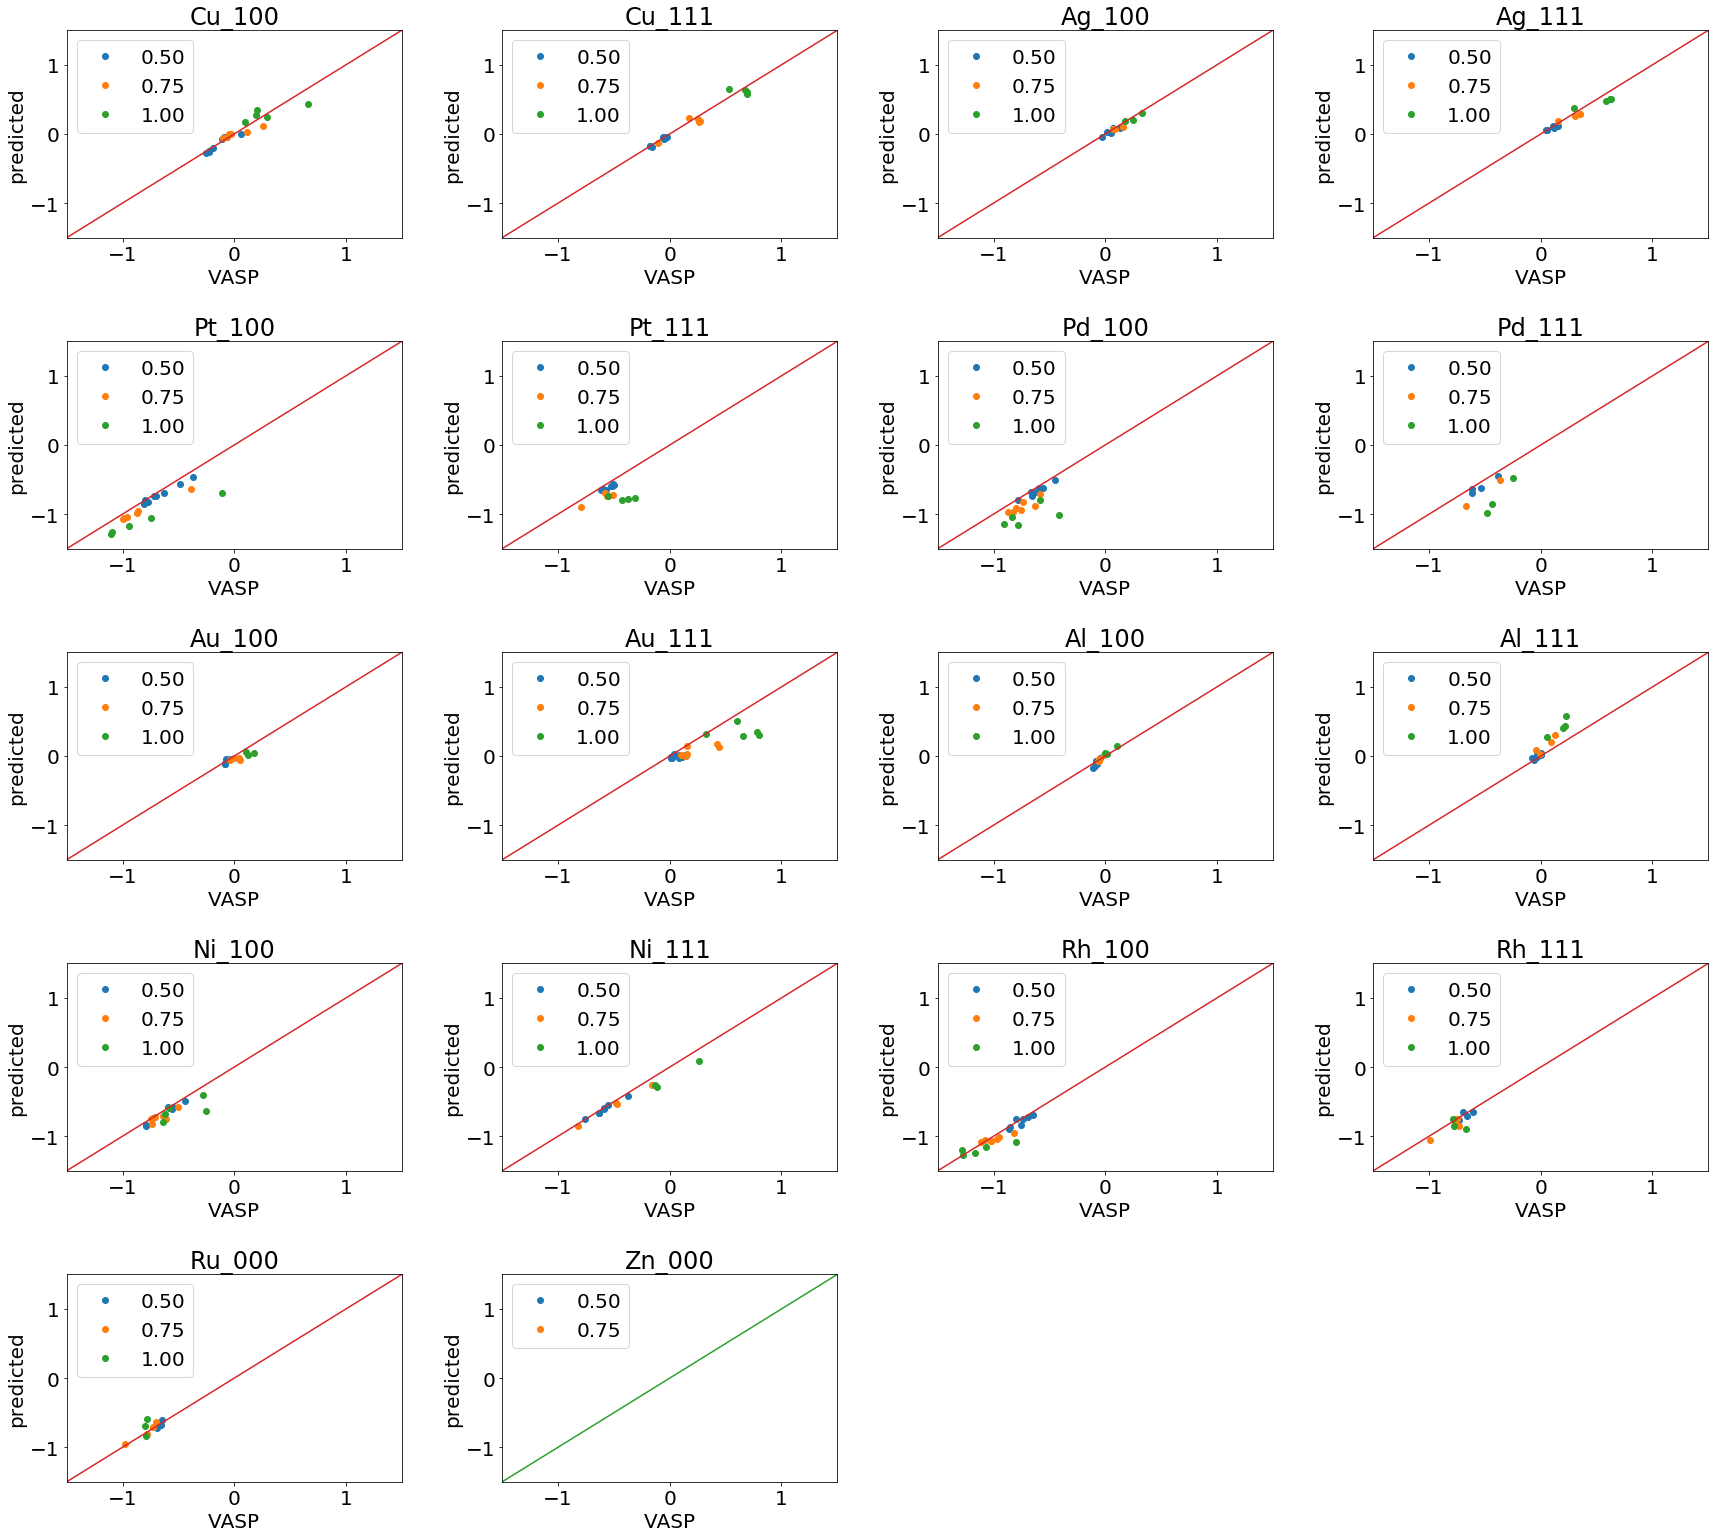

In [9]:
xrange = np.linspace(-2, 2)

fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20
for i in range(len(dfpred)):
    ax = fig.add_subplot(5, 4, i+1)
    xmin = 100
    xmax = -100
    dfpred[i]['predE/surfatom'] = 0
    dfpred[i]['sumadsE/surfatom'] = 0
    dfpred[i]['Eint/surfatom'] = 0
    for j in range(len(dfpred[i])):
        try:
            predadsene_surf, adsElis, Eint = predE(i, dfpred[i].iloc[j], True, False)
            dfpred[i].iloc[j, -3] = predadsene_surf
            dfpred[i].iloc[j, -2] = sum(adsElis)/dfpred[i].iloc[j]['surfatomnum']
            dfpred[i].iloc[j, -1] = Eint/dfpred[i].iloc[j]['surfatomnum']
        except:
#             print('Error in finding one adsorbate result.')
            dfpred[i].iloc[j, -3] = None
            dfpred[i].iloc[j, -2] = None
            dfpred[i].iloc[j, -1] = None

    for j in range(len(covset[i])):
        predElis = list(dfpred[i][dfpred[i]['coverage'] == covset[i][j]]['predE/surfatom'])
        calcElis = list(dfpred[i][dfpred[i]['coverage'] == covset[i][j]]['aveadsEne/suratom'])
        if calcElis == []:
            continue
        if xmin > np.min(calcElis):
            xmin = np.min(calcElis)
        if xmax < np.max(calcElis):
            xmax = np.max(calcElis)
        ax.plot(calcElis, predElis, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('VASP')
    ax.set_ylabel('predicted')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
# plt.savefig('')
plt.show()

In [10]:
for i in range(len(dfpred)):
    dfpred[i]['VASP - prediction'] = dfpred[i]['aveadsEne/suratom'] - dfpred[i]['predE/surfatom']    

In [11]:
# 0 :Cu 100
# 1 :Cu 111
# 2 :Ag 100
# 3 :Ag 111
# 4 :Pt 100
# 5 :Pt 111
# 6 :Pd 100
# 7 :Pd 111
# 8 :Au 100
# 9 :Au 111
# 10:Al 100
# 11:Al 111
# 12:Ni 100           
# 13:Ni 111

In [13]:
id = 1
env = 'local'
ele_mir = 0

name = dfpred[ele_mir].iloc[id]['name']
allname = dfpred[ele_mir].iloc[id]['name'][:-5] + '_all.traj'
# query(name, env)
# query(allname, env)

In [14]:
for i in range(len(dfpred)):
    dfpred[i]['nbdist'] = None # nearest bonding distance
    dfpred[i]['#dist2ads'] = None # nearest bonding distance
    dfpred[i]['#dist3ads'] = None # nearest bonding distance
    dfpred[i]['#dist4ads'] = None # nearest bonding distance
    for j in range(len(dfpred[i])):
        name = dfpred[i].iloc[j]['name']
        atoms = query(name)
        repeat = 3 # repeat
        ratoms = get_repeated_atoms(atoms, repeat)

        b_mat, nads = get_modified_bonding_matrix(ratoms)
        results = get_number_matrix(b_mat, nads, repeat)
        try:
            if results[0,1] != 0:
                nbdist = 2
            elif results[1,1] != 0:
                nbdist = 3
            elif repeat == 3:
                nbdist = None
            elif results[2,1] != 0:
                nbdist = 4
            else:
                nbdist = None
            if repeat == 3:
                print(name, nbdist, results[0,1], results[1,1])
            else:
                print(name, nbdist, results[0,1], results[1,1], results[2,1])
            dfpred[i].iloc[j, -4] = nbdist
            dfpred[i].iloc[j, -3] = results[0,1]
            dfpred[i].iloc[j, -2] = results[1,1]
            if repeat == 5:
                dfpred[i].iloc[j, -1] = results[2,1]
        except:
            print('Error')

Cu_100_u2_no02_CO_n2_d3.traj 3 0.0 0.5
Cu_100_u2_no03_CO_n3_d3.traj 3 0.0 1.0
Cu_100_u2_no04_CO_n4_d3.traj 3 0.0 2.0
Cu_100_u2_no05_CO_n3_d3.traj 3 0.0 1.0625
Cu_100_u2_no06_CO_n4_d3.traj 2 1.0 1.625
Cu_100_u2_no07_CO_n2_d5.traj None 0.0 0.0
Cu_100_u2_no08_CO_n2_d3.traj 3 0.0 0.3125
Cu_100_u2_no09_CO_n3_d3.traj 2 1.0 0.625
Cu_100_u2_no11_CO_n2_d3.traj 3 0.0 0.375
Cu_100_u2_no13_CO_n4_d3.traj 2 2.0 1.25
Cu_100_u2_no14_CO_n3_d3.traj 2 1.0 0.5625
Cu_100_u2_no15_CO_n4_d3.traj 2 2.5 0.8125
Cu_100_u2_no16_CO_n2_d5.traj 3 0.0 0.375
Cu_100_u2_no18_CO_n3_d3.traj 2 1.5 0.375
Cu_100_u2_no19_CO_n2_d3.traj 2 1.0 0.125
Cu_100_u2_no21_CO_n2_d3.traj 2 0.5 0.1875
Cu_100_u2_no22_CO_n3_d3.traj 2 1.5 0.3125
Cu_100_u2_no23_CO_n4_d3.traj 2 3.0 0.5
Cu_100_u2_no24_CO_n2_d5.traj 2 0.5 0.125
Cu_111_u2_no02_CO_n2_d3.traj 3 0.0 0.4444444444444444
Cu_111_u2_no03_CO_n3_d3.traj 3 0.0 1.3333333333333333
Cu_111_u2_no04_CO_n4_d3.traj 3 0.0 2.6666666666666665
Cu_111_u2_no05_CO_n2_d4.traj 3 0.0 0.5185185185185186
Cu_111_

Au_111_u2_no024_CO_n2_d3.traj 2 1.0 0.1111111111111111
Au_111_u2_no025_CO_n2_d4.traj 2 0.6666666666666666 0.2037037037037037
Au_111_u2_no029_CO_n3_d3.traj 2 1.5 0.6666666666666667
Au_111_u2_no030_CO_n4_d3.traj 2 2.6666666666666665 0.8888888888888888
Au_111_u2_no031_CO_n2_d4.traj 2 0.6666666666666667 0.14814814814814814
Au_111_u2_no034_CO_n3_d3.traj 2 1.5 0.6666666666666667
Au_111_u2_no035_CO_n4_d3.traj 2 2.6666666666666665 0.8888888888888888
Al_100_u2_no002_CO_n2_d3.traj 3 0.0 0.5
Al_100_u2_no003_CO_n3_d3.traj 3 0.0 1.0
Al_100_u2_no004_CO_n4_d3.traj 3 0.0 2.0
Al_100_u2_no005_CO_n3_d3.traj 3 0.0 1.1071428571428572
Al_100_u2_no006_CO_n4_d3.traj 2 1.0 1.625
Al_100_u2_no007_CO_n2_d6.traj None 0.0 0.0
Al_100_u2_no008_CO_n2_d4.traj 3 0.0 0.33928571428571425
Al_100_u2_no009_CO_n3_d3.traj 2 1.0 0.625
Al_100_u2_no011_CO_n2_d3.traj 3 0.0 0.4285714285714285
Al_100_u2_no012_CO_n3_d3.traj 2 1.0 0.7321428571428571
Al_100_u2_no013_CO_n4_d3.traj 2 2.0 1.25
Al_100_u2_no014_CO_n3_d3.traj 2 1.0 0.6071428

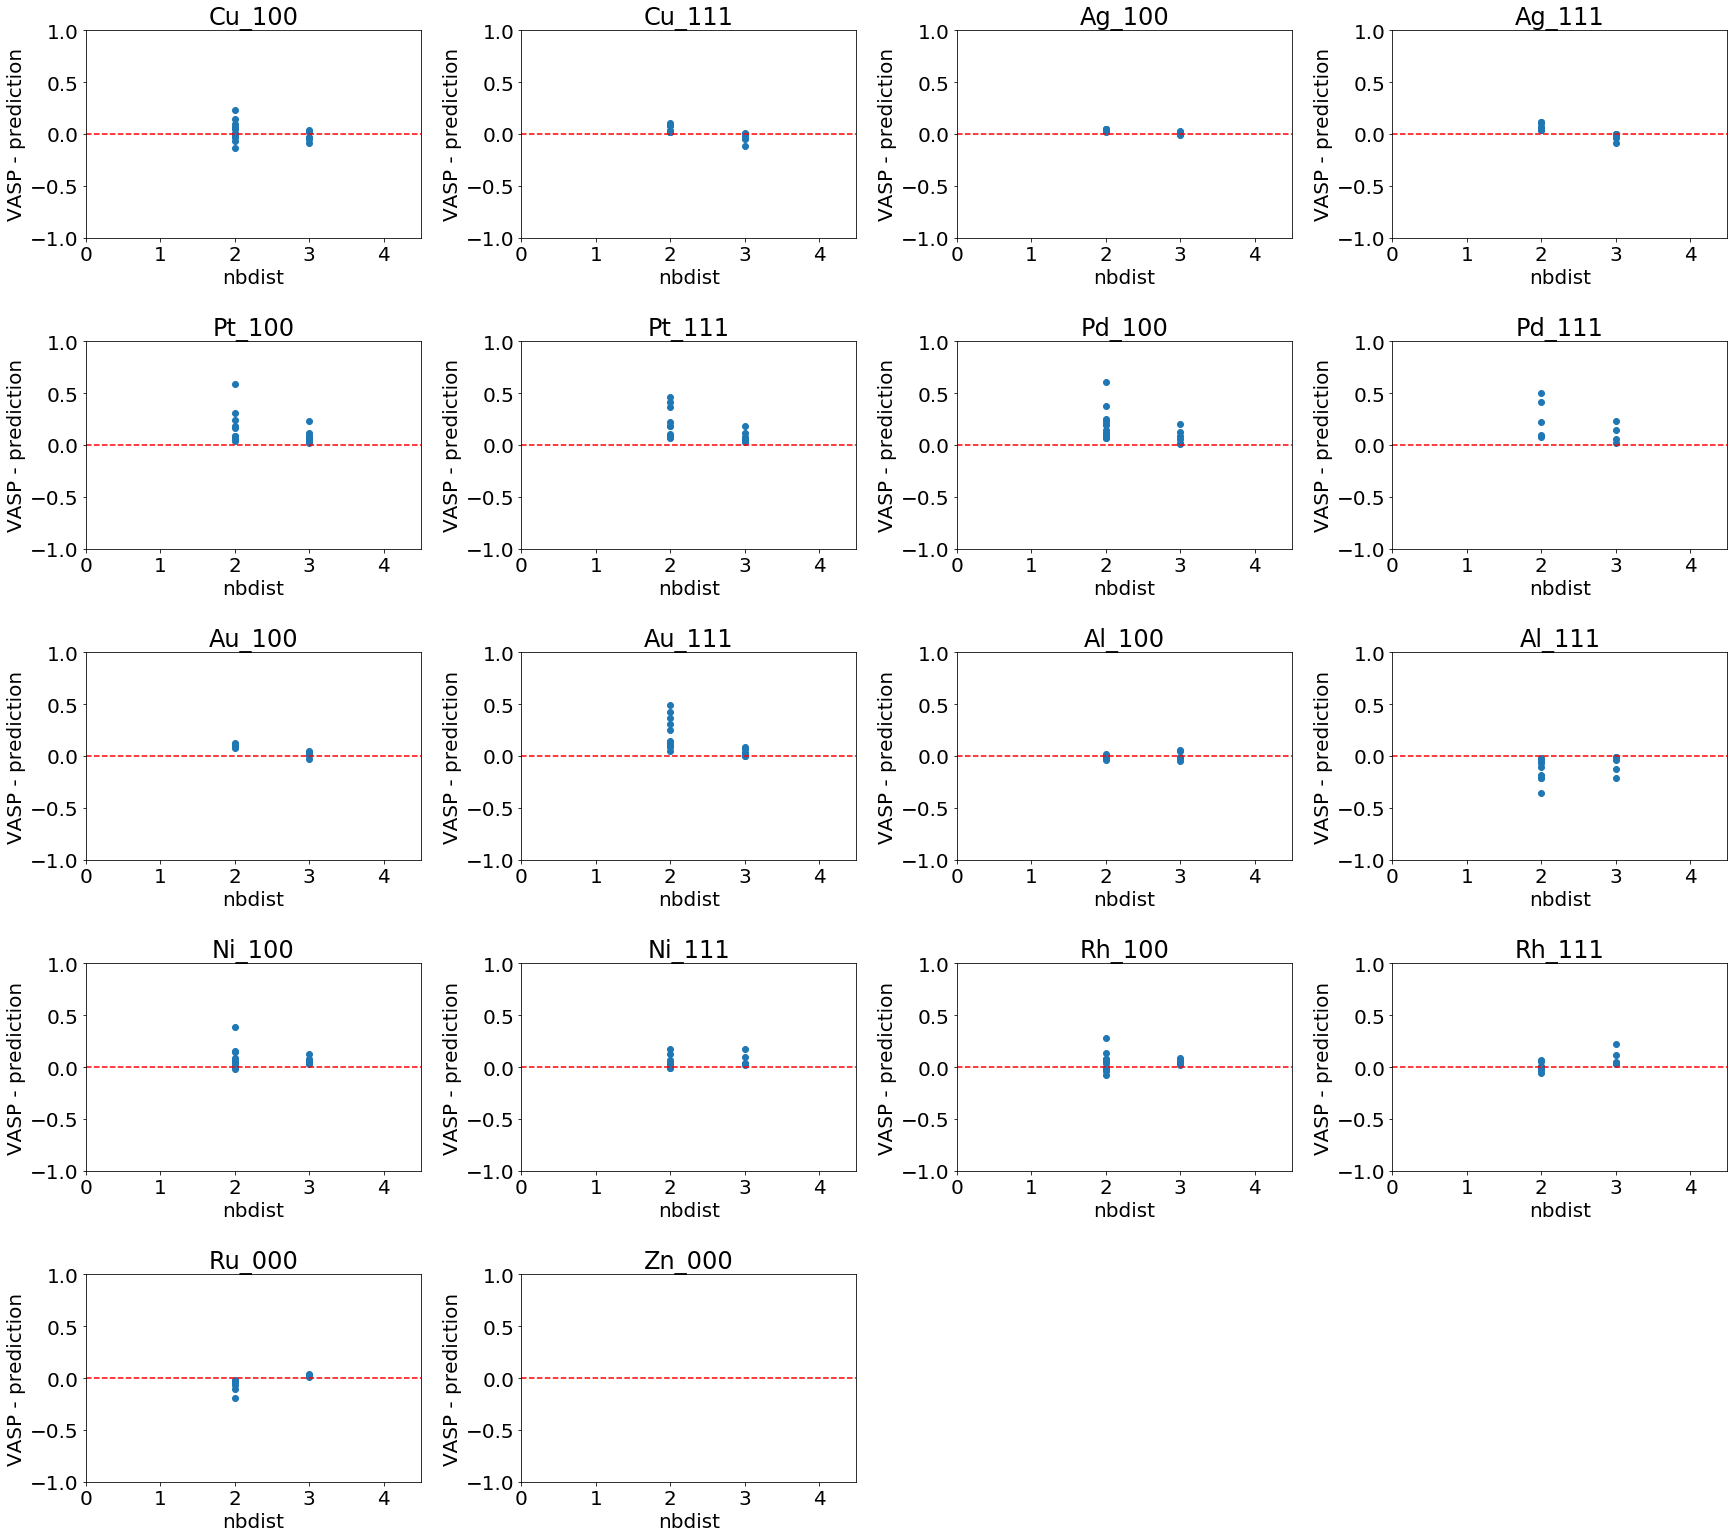

In [20]:
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20

xmin = 0
xmax = 4.5
for i in range(len(dfpred)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(dfpred[i]['nbdist'], dfpred[i]['VASP - prediction'], 'o')
    ax.plot([xmin,xmax],[0,0], "red", linestyle='dashed') # normal way

    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    ax.set_xlabel('nbdist')
    ax.set_ylabel('VASP - prediction')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
# plt.savefig('')
    plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.show()

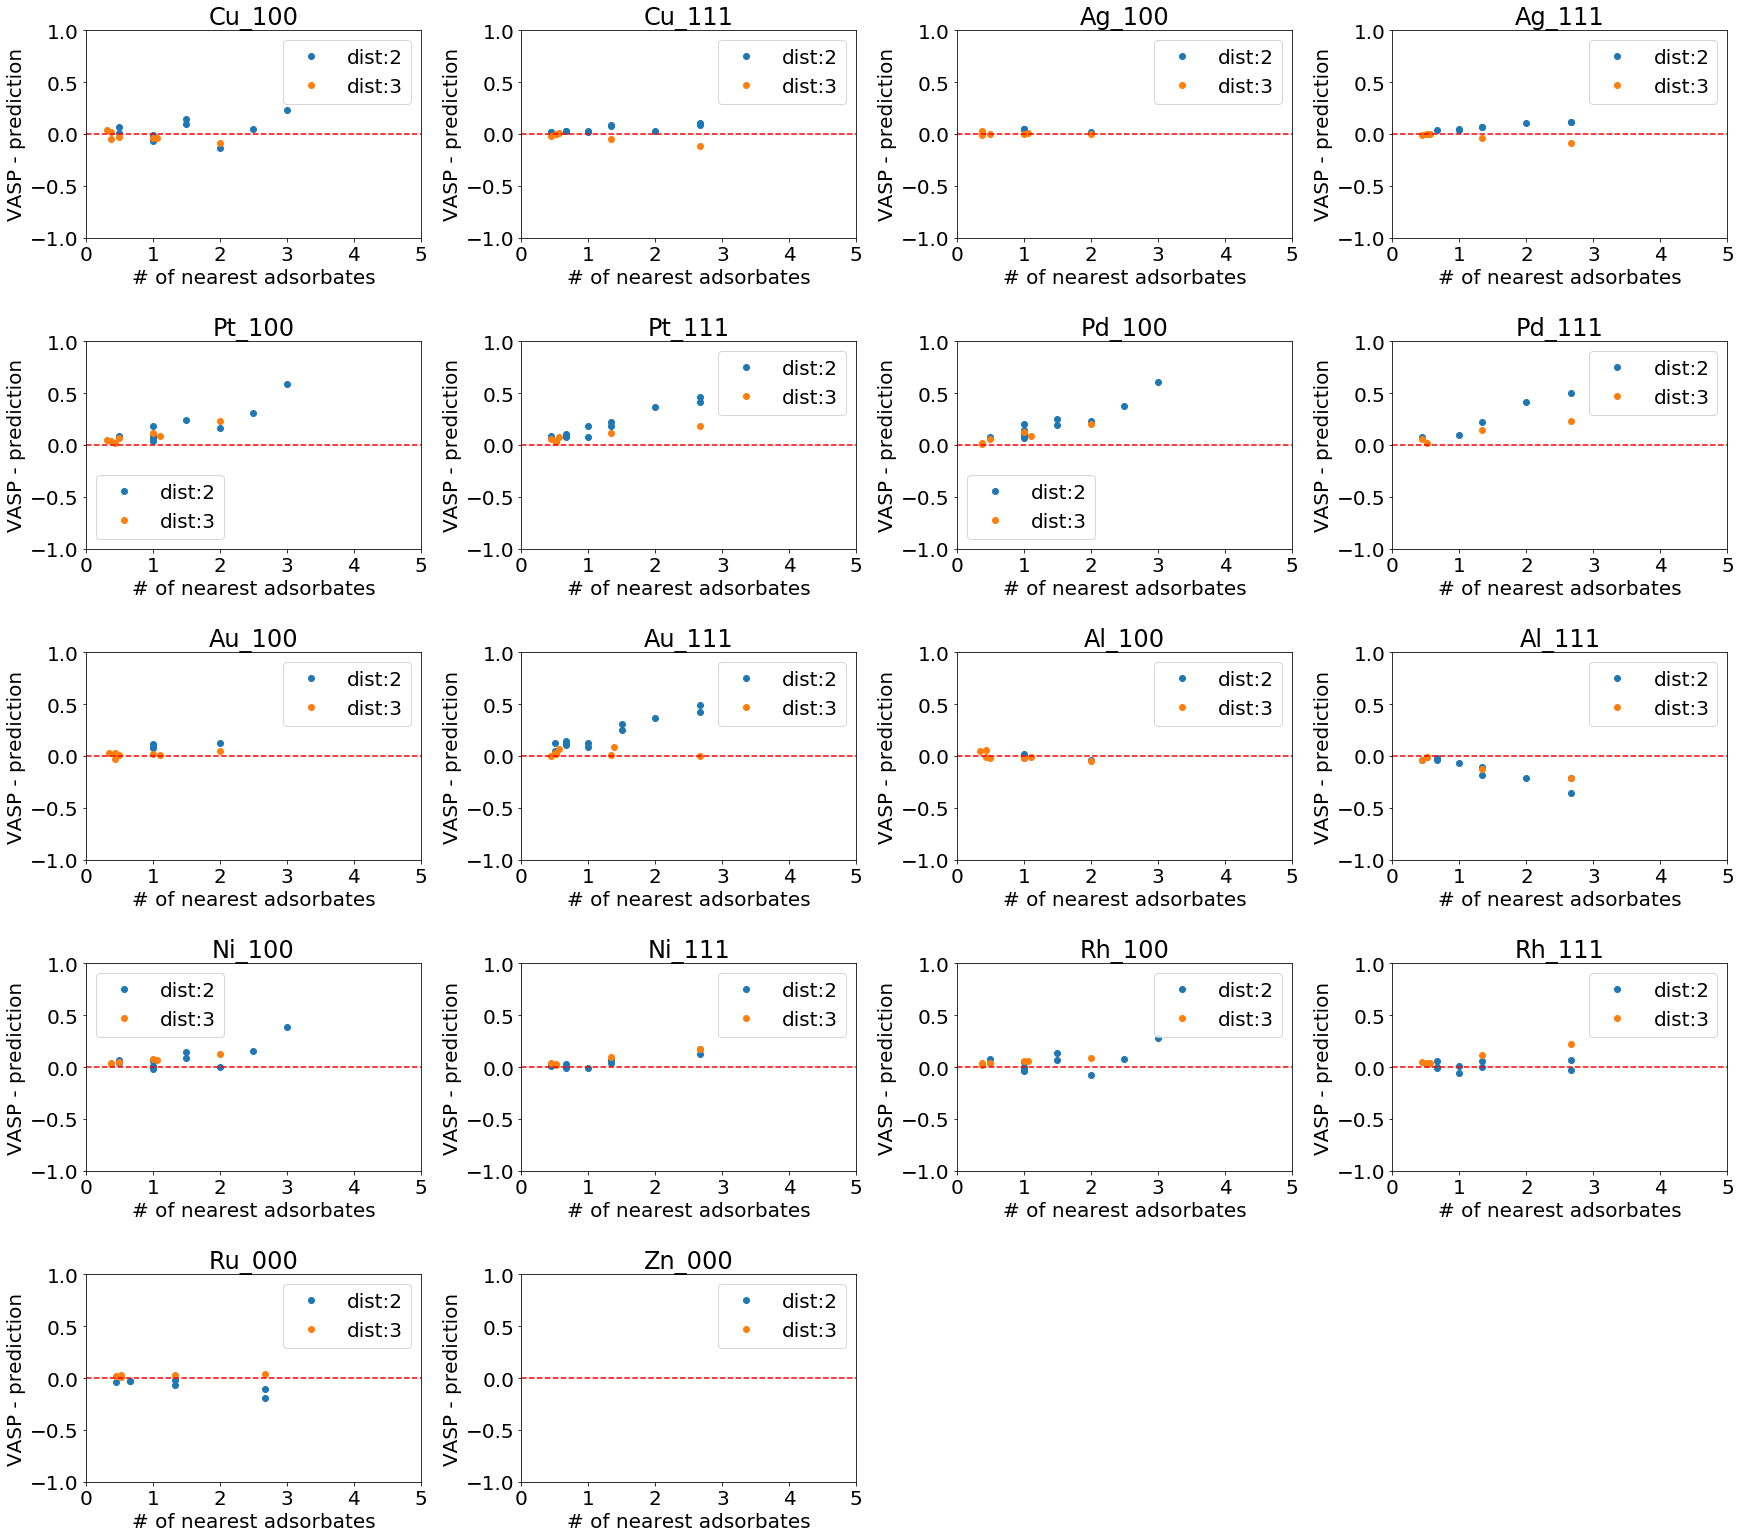

In [28]:
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20

xmin = 0
xmax = 5
# nbdist = 2
for i in range(len(dfpred)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(dfpred[i][dfpred[i]['nbdist']==2]['#dist2ads'], dfpred[i][dfpred[i]['nbdist']==2]['VASP - prediction'], 'o')
    ax.plot(dfpred[i][dfpred[i]['nbdist']==3]['#dist3ads'], dfpred[i][dfpred[i]['nbdist']==3]['VASP - prediction'], 'o')
#     ax.plot(dfpred[i][dfpred[i]['nbdist']==4]['#nbads'], dfpred[i][dfpred[i]['nbdist']==4]['VASP - prediction'], 'o')
    ax.plot([xmin,xmax],[0,0], "red", linestyle='dashed') # normal way
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    ax.set_xlabel('# of nearest adsorbates')
    ax.set_ylabel('VASP - prediction')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    plt.legend(['dist:2','dist:3'])
# plt.savefig('')
    plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.show()

In [29]:
def linearfit(X, y):
    Lin.fit(X, y)
    y_pred = Lin.predict(X)
    slope = Lin.coef_
    return y_pred, slope

In [30]:
from sklearn.linear_model import LinearRegression
Lin = LinearRegression(fit_intercept=False)

In [ ]:
# For each mirror

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

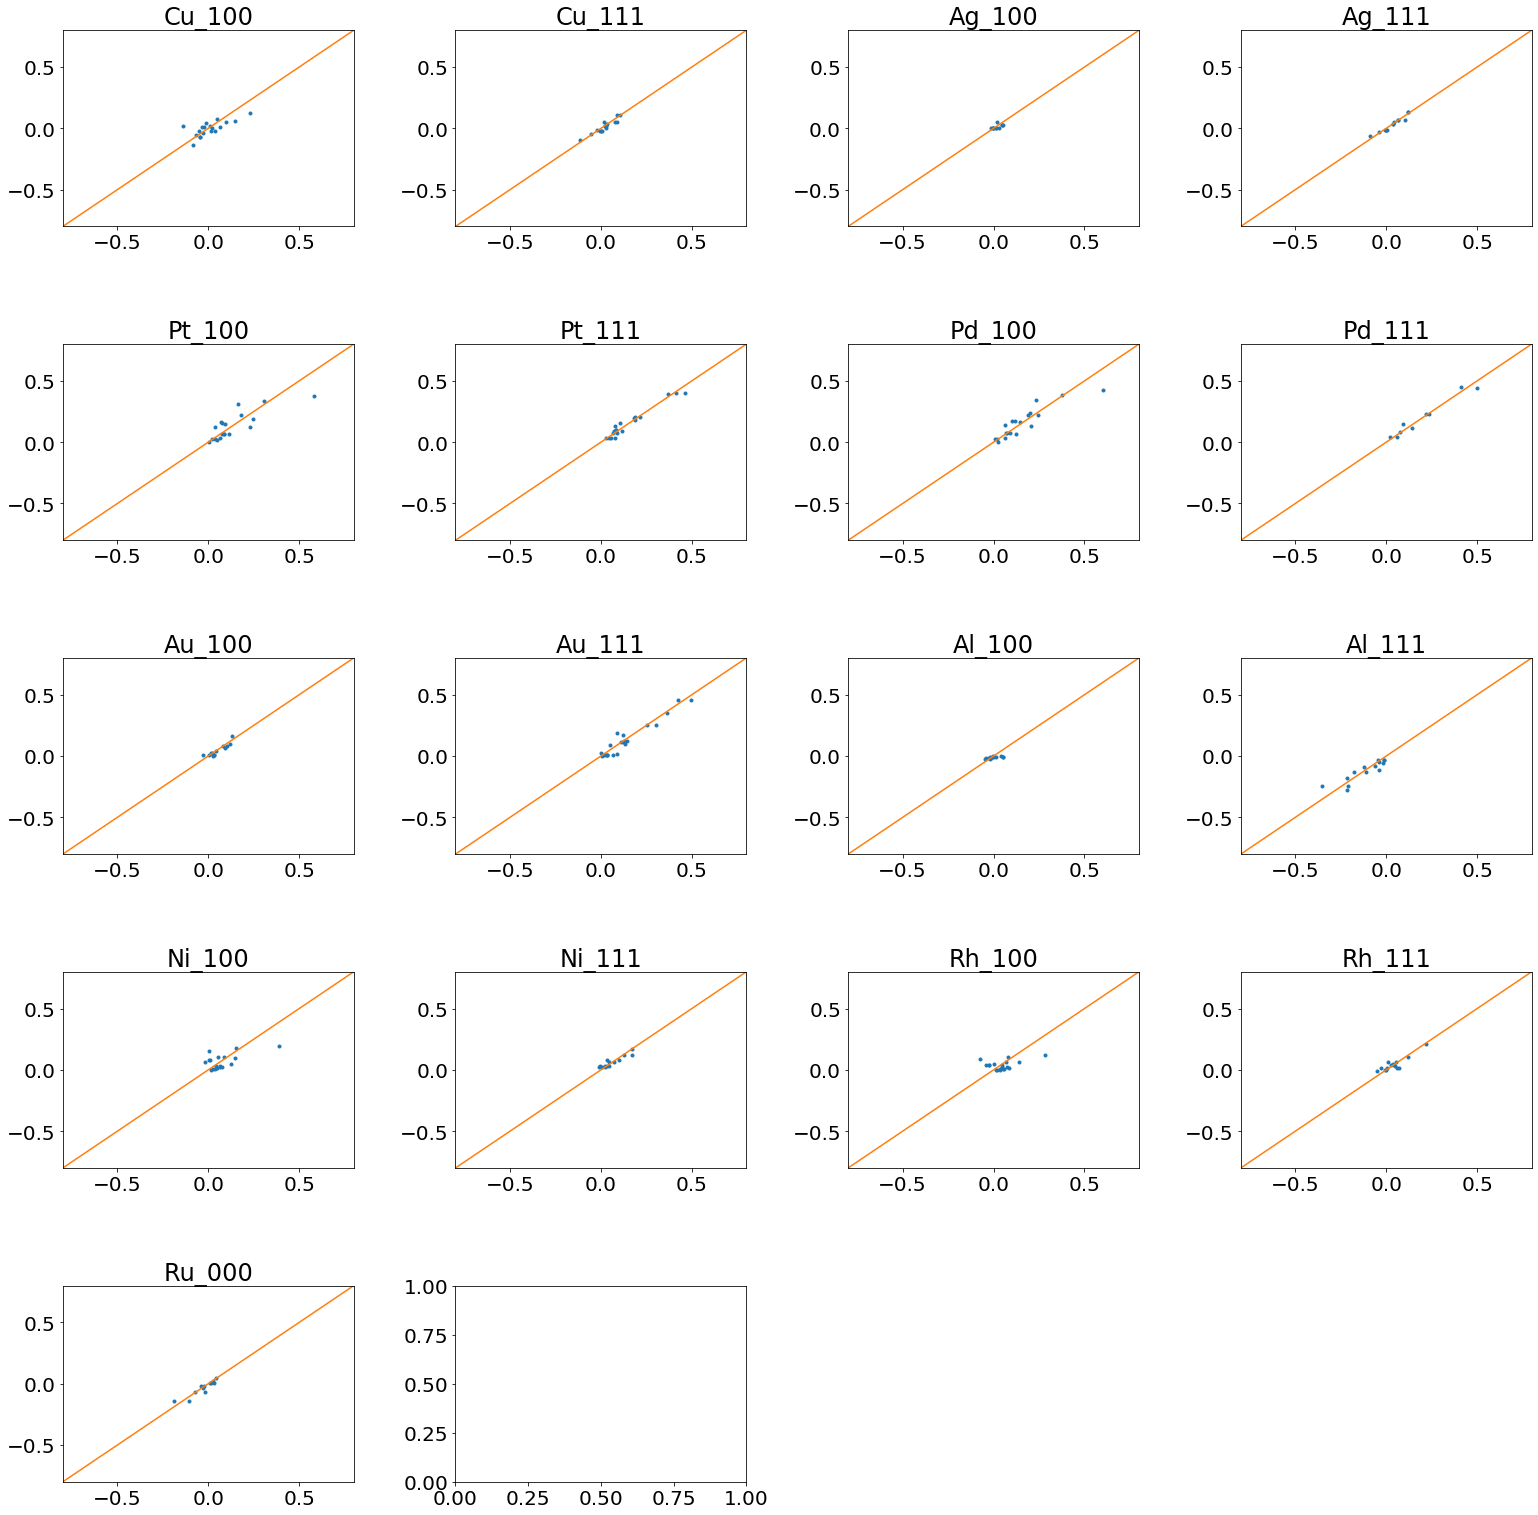

In [41]:
fig = plt.figure(figsize=(24,24))

for i in range(len(dfpred)):
    tmpdfpred = dfpred[i].dropna(subset=['VASP - prediction'])
    ax = fig.add_subplot(5, 4, i+1)
    plt.rcParams["font.size"] = 20

    y = tmpdfpred['VASP - prediction']
    X = tmpdfpred[['#dist2ads','#dist3ads']]
    y_pred, slope = linearfit(X, y)
    plt.xlim(-0.8, 0.8)
    plt.ylim(-0.8, 0.8)
    ax.plot(y, y_pred, '.')
    ax.plot(xrange, xrange, '-')
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.6, wspace=0.35)
plt.show()

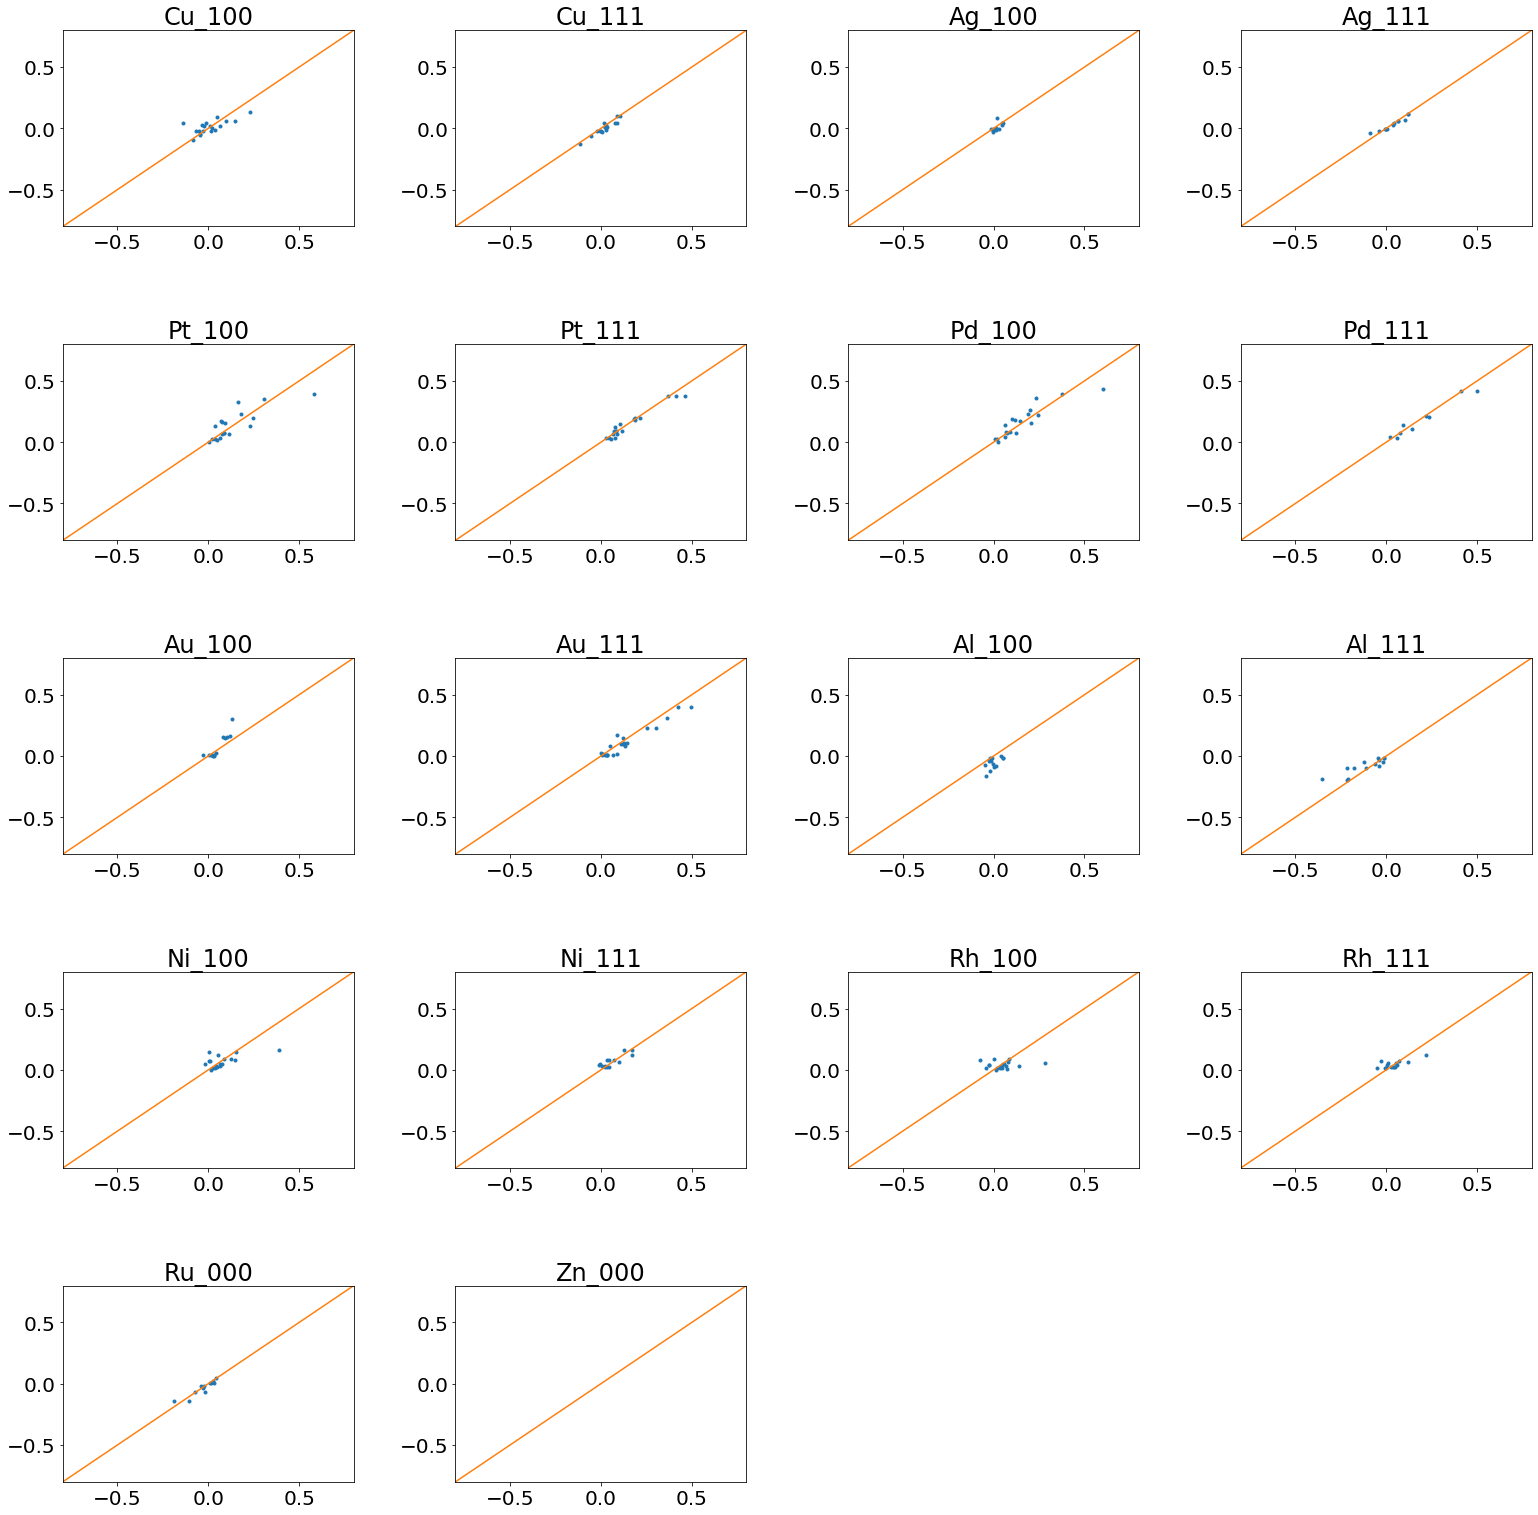

In [46]:
fig = plt.figure(figsize=(24,24))
slopes= []

for i in range(len(dfpred)):
    j = i//2*2
    tmpdfpred = dfpred[j].dropna(subset=['VASP - prediction']).append(dfpred[j+1].dropna(subset=['VASP - prediction']), sort=False)
    ax = fig.add_subplot(5, 4, i+1)
    plt.rcParams["font.size"] = 20

    y = tmpdfpred['VASP - prediction']
    X = tmpdfpred[['#dist2ads','#dist3ads']]
    y_pred, slope = linearfit(X, y)
    slopes.append(slope)

    tmpdfpred = dfpred[i].dropna(subset=['VASP - prediction'])
    y = tmpdfpred['VASP - prediction']
    X = tmpdfpred[['#dist2ads','#dist3ads']]
    y_pred = X @ slope
    
    plt.xlim(-0.8, 0.8)
    plt.ylim(-0.8, 0.8)
    ax.plot(y, y_pred, '.')
    ax.plot(xrange, xrange, '-')
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.6, wspace=0.35)
plt.show()

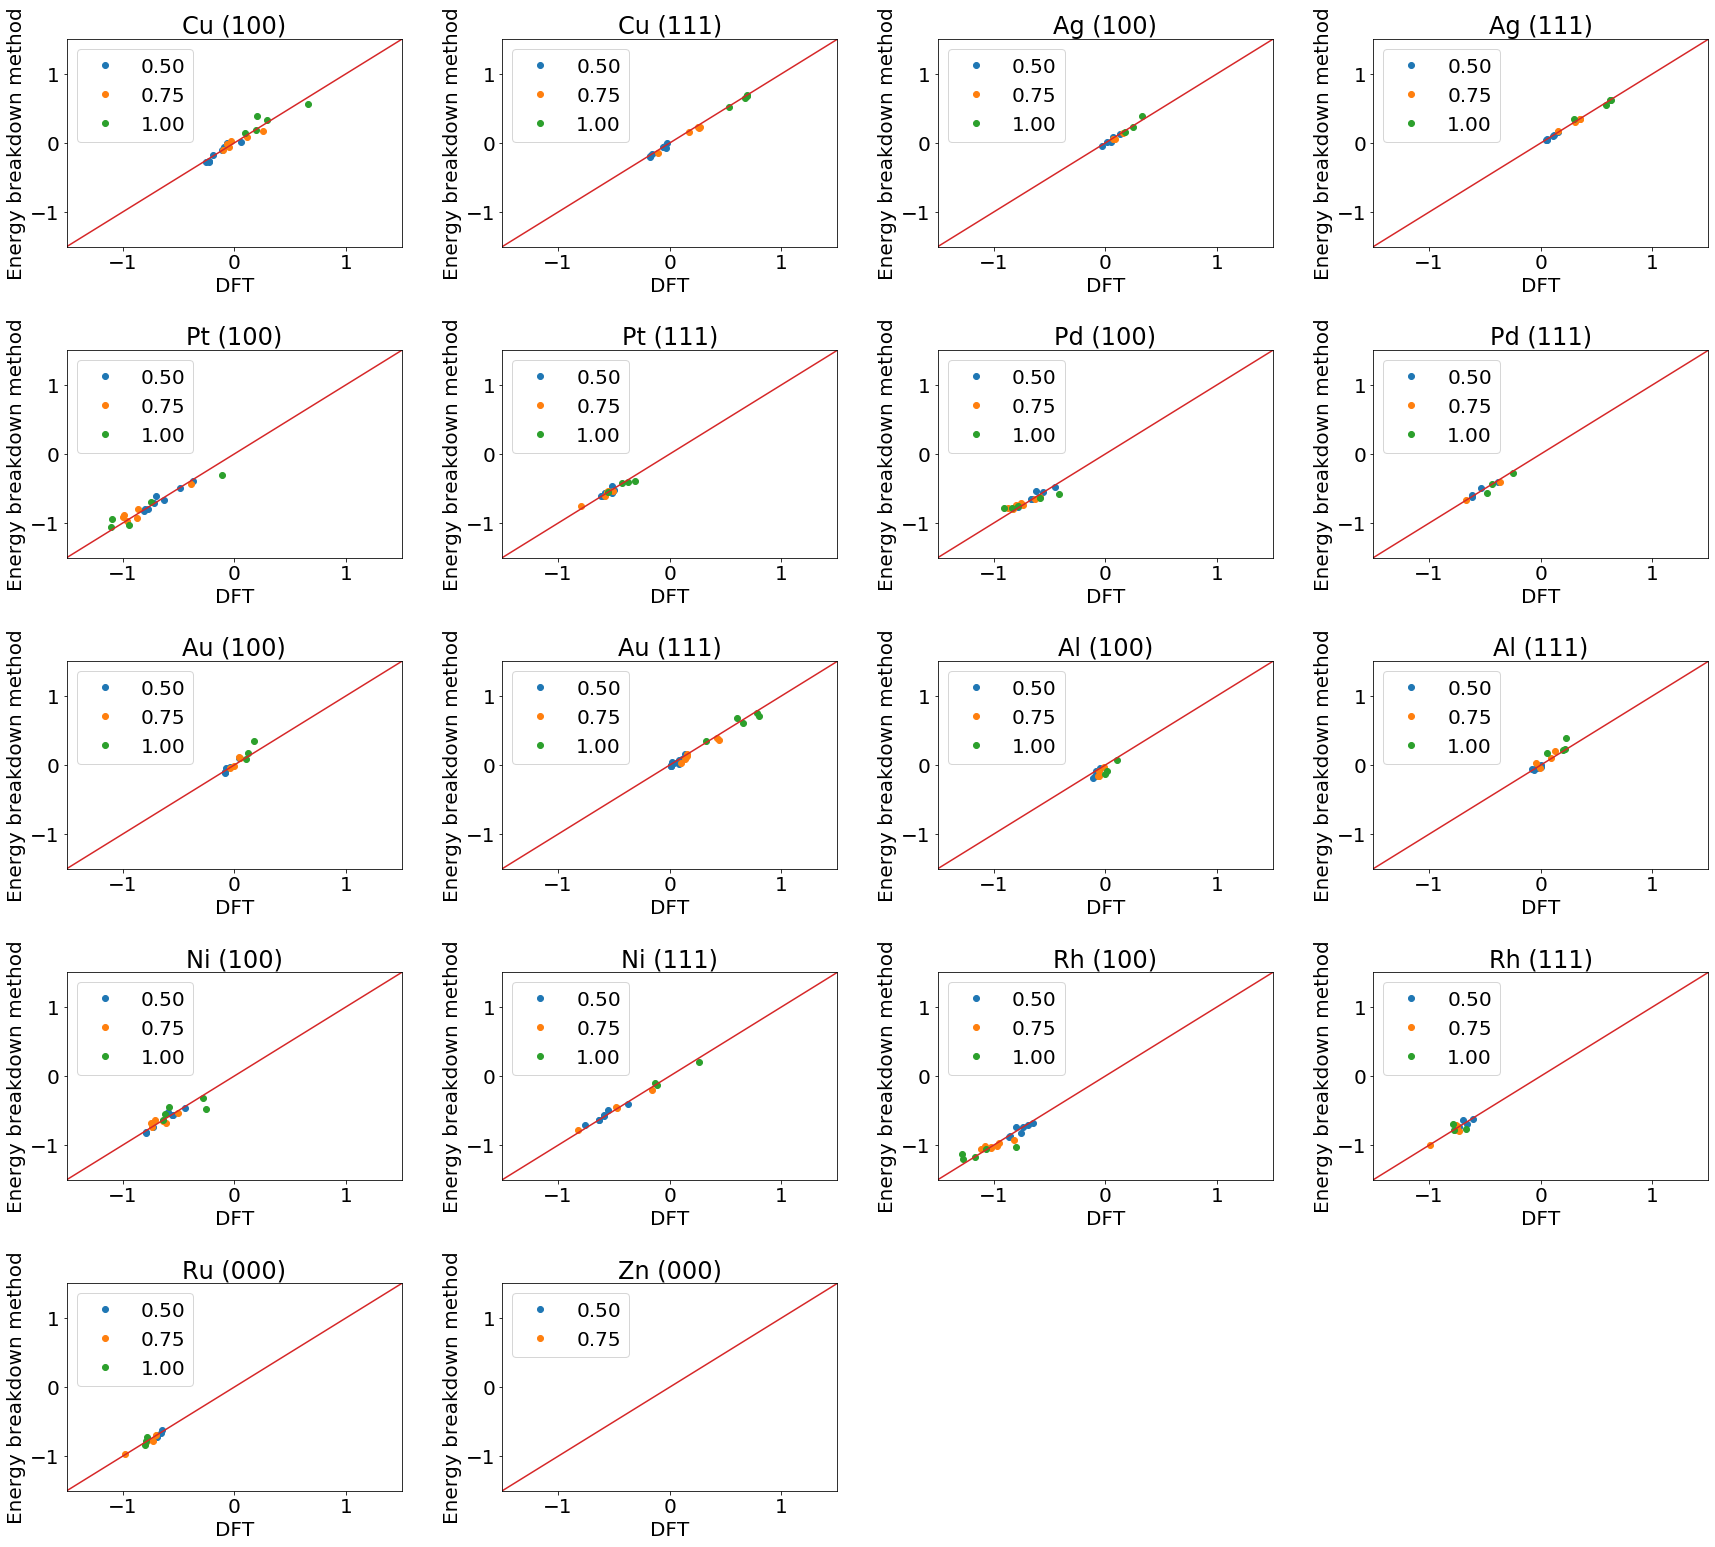

In [61]:
xrange = np.linspace(-2, 2)

fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20
for i in range(len(dfpred)):
    ax = fig.add_subplot(5, 4, i+1)
    xmin = 100
    xmax = -100
    dfpred[i]['newpredE/surfatom'] = 0
    for j in range(len(dfpred[i])):
        try:
            dfpred[i].iloc[j, -1] = dfpred[i].iloc[j]['predE/surfatom'] + slopes[i][0]*dfpred[i].iloc[j]['#dist2ads'] + slopes[i][1]*dfpred[i].iloc[j]['#dist3ads']
        except:
#             print('Error in finding one adsorbate result.')
            dfpred[i].iloc[j, -1] = None
            
    for j in range(len(covset[i])):
        predElis = list(dfpred[i][dfpred[i]['coverage'] == covset[i][j]]['newpredE/surfatom'])
        calcElis = list(dfpred[i][dfpred[i]['coverage'] == covset[i][j]]['aveadsEne/suratom'])
        if calcElis == []:
            continue
        if xmin > np.min(calcElis):
            xmin = np.min(calcElis)
        if xmax < np.max(calcElis):
            xmax = np.max(calcElis)
        ax.plot(calcElis, predElis, 'o')
    ax.plot(xrange, xrange, '-', color="#d62728")
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{} ({})'.format(dictlis[i]['element'], dictlis[i]['mirror']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('Energy breakdown method')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
plt.savefig('200212.png',format='png', bbox_inches="tight")
plt.show()